Importing Required Libraries


In [122]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Reading the given dataset

In [123]:
train_df = pd.read_csv('pirvision_office_dataset1.csv')
train_df.head(5)

,Date,Time,Label,Temperature_F,PIR_1,PIR_2,PIR_3,PIR_4,PIR_5,PIR_6,...,PIR_46,PIR_47,PIR_48,PIR_49,PIR_50,PIR_51,PIR_52,PIR_53,PIR_54,PIR_55
0,2024-08-08,19:19:56,0,86,10269,10721,11156,11170,10931,10671,...,11178,11197,11161,11096,10957,10839,10735,10590,10411,10329
1,2024-08-08,19:20:12,1,86,10364,10907,11299,11238,10867,10535,...,11122,11145,11136,11108,11041,10824,10645,10493,10398,10357
2,2024-08-08,19:20:28,0,86,10329,10793,11197,11242,11052,10658,...,11168,11204,11162,11109,11007,10867,10700,10533,10427,10265
3,2024-08-08,19:20:44,0,86,10169,10425,10822,11133,11136,10834,...,11116,11273,11186,10984,10910,10807,10714,10651,10562,10463
4,2024-08-08,19:21:00,0,86,10320,10667,11104,11234,11129,10814,...,11006,11257,11370,11173,10924,10816,10754,10588,10428,10407


Finding the number of null values in each column

In [124]:
def null_vals(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'missing Values', 1 : '% of total values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of total values', ascending=False).round(1)
        print ("dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [125]:
missing_vals = null_vals(train_df)
missing_vals

dataframe has 59 columns.
There are 0 columns that have missing values.


,missing Values,% of total values


We found that there are no null values in the given dataset


Finding the number of different labels
and their frequencies

In [126]:
print("Number of labels and their frequencies:\n",train_df['Label'].value_counts())

Number of labels and their frequencies:
 Label
0    6247
1     833
3     571
Name: count, dtype: int64


Finding the number of different temperatures
and their frequencies

In [127]:
print("Number of labels and their frequencies:\n",train_df['Temperature_F'].value_counts())

Number of labels and their frequencies:
 Temperature_F
86    2553
88    1470
87    1253
89     937
85     867
0      571
Name: count, dtype: int64


Plotting PIR vlaues for each label

<ipython-input-128-925891018ff6>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  samples_per_label = train_df.groupby('Label').apply(lambda x: x.sample(n=2, random_state=42)).reset_index(drop=True)


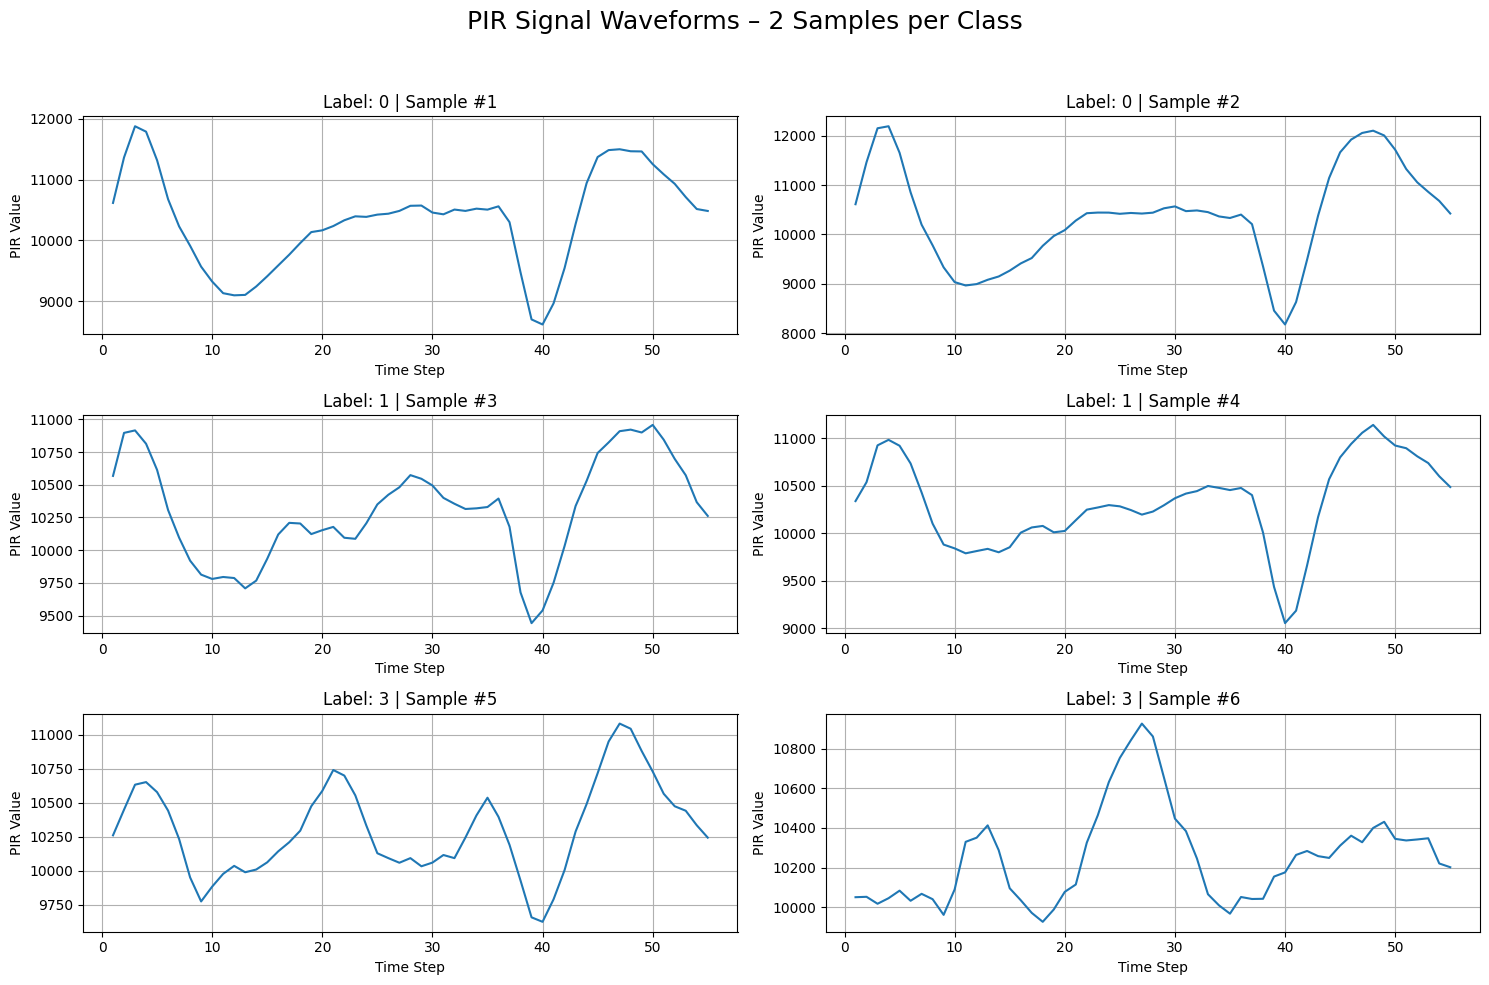

In [128]:
pir_columns = [f'PIR_{i+1}' for i in range(55)]

# Group by label and select 2 samples from each class
samples_per_label = train_df.groupby('Label').apply(lambda x: x.sample(n=2, random_state=42)).reset_index(drop=True)

# Plotting
fig, axes = plt.subplots(nrows=len(samples_per_label['Label'].unique()), ncols=2, figsize=(15, 10))
fig.suptitle("PIR Signal Waveforms – 2 Samples per Class", fontsize=18)

for i, (idx, row) in enumerate(samples_per_label.iterrows()):
    pir_signal = row[pir_columns].values.astype(float)
    label = row['Label']
    ax = axes[i // 2, i % 2]
    ax.plot(range(1, 56), pir_signal)
    ax.set_title(f"Label: {label} | Sample #{i+1}")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("PIR Value")
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Finding the minimum and maximum values for each PIR column

In [129]:
pir_columns = [col for col in train_df.columns if col.startswith("PIR_")]
pir_min = train_df[pir_columns].min()
pir_max = train_df[pir_columns].max()
print("min values:\n", pir_min)
print("max values:\n", pir_max)

min values:
 PIR_1     2613
PIR_2     2615
PIR_3     2614
PIR_4     2611
PIR_5     2612
PIR_6     2613
PIR_7     2616
PIR_8     2614
PIR_9     2615
PIR_10    2614
PIR_11    2611
PIR_12    2605
PIR_13    2602
PIR_14    2603
PIR_15    2611
PIR_16    2613
PIR_17    2614
PIR_18    2613
PIR_19    2612
PIR_20    2612
PIR_21    2613
PIR_22    2614
PIR_23    2614
PIR_24    2618
PIR_25    2619
PIR_26    2618
PIR_27    2615
PIR_28    2615
PIR_29    2615
PIR_30    2615
PIR_31    2614
PIR_32    2613
PIR_33    2614
PIR_34    2614
PIR_35    2612
PIR_36    2614
PIR_37    2609
PIR_38    2611
PIR_39    2612
PIR_40    2612
PIR_41    2612
PIR_42    2611
PIR_43    2611
PIR_44    2613
PIR_45    2610
PIR_46    2606
PIR_47    2606
PIR_48    2606
PIR_49    2605
PIR_50    2605
PIR_51    2609
PIR_52    2605
PIR_53    2604
PIR_54    2603
PIR_55    2602
dtype: int64
max values:
 PIR_1     111602625
PIR_2         16383
PIR_3         16383
PIR_4         16383
PIR_5         16383
PIR_6         16383
PIR_7         16

Sometimes PIR 1 value is exploding when compared to the other PIR values

Finding mean and standard deviation for each PIR column

In [130]:
pir_stats = train_df[pir_columns].agg(['mean', 'std'])
pir_means = train_df[pir_columns].mean()
pir_stds = train_df[pir_columns].std()

print("mean values:\n", pir_means)
print("\nStandard deviation values:\n", pir_stds)

mean values:
 PIR_1     250125.620572
PIR_2      11013.891648
PIR_3      11517.838452
PIR_4      11578.490786
PIR_5      11269.104169
PIR_6      10795.036989
PIR_7      10312.208600
PIR_8       9907.840413
PIR_9       9610.574958
PIR_10      9421.211214
PIR_11      9327.678212
PIR_12      9311.812181
PIR_13      9355.004313
PIR_14      9442.985753
PIR_15      9557.784211
PIR_16      9685.499673
PIR_17      9815.936871
PIR_18      9939.873742
PIR_19     10052.869560
PIR_20     10150.338256
PIR_21     10232.754411
PIR_22     10300.758724
PIR_23     10353.762776
PIR_24     10395.873611
PIR_25     10425.507777
PIR_26     10444.600444
PIR_27     10456.671546
PIR_28     10460.038296
PIR_29     10454.110051
PIR_30     10446.378905
PIR_31     10437.645014
PIR_32     10427.139067
PIR_33     10416.795190
PIR_34     10406.123383
PIR_35     10395.103516
PIR_36     10382.407921
PIR_37     10240.095543
PIR_38      9643.828127
PIR_39      8959.425042
PIR_40      8717.708535
PIR_41      8986.531957
PI

The following code cell is for finding the temperature to label mapping

In [131]:
temp_label_counts = train_df.groupby(['Temperature_F', 'Label']).size().reset_index(name='Count')
temp_label_pivot = temp_label_counts.pivot(index='Temperature_F', columns='Label', values='Count').fillna(0)
print(temp_label_pivot)
temp_label_pivot_sorted = temp_label_pivot.sort_index()

Label               0      1      3
Temperature_F                      
0                 0.0    0.0  571.0
85              856.0   11.0    0.0
86             1745.0  808.0    0.0
87             1239.0   14.0    0.0
88             1470.0    0.0    0.0
89              937.0    0.0    0.0


We can see above that, if and only if the Temperature is 0, label is 3

In [132]:
train_df['Datetime'] = pd.to_datetime(train_df['Date'] + ' ' + train_df['Time'])

train_df['Datetime'] = pd.to_datetime(train_df['Datetime'])
train_df['Hour'] = train_df['Datetime'].dt.hour


label_counts_per_hour = train_df.groupby('Hour')['Label'].value_counts().unstack(fill_value=0)

print("Number of labels per hour:")
print(label_counts_per_hour)

Number of labels per hour:
Label    0    1    3
Hour                
0      450    0    0
1      450    0    0
2      450    0    0
3      450    0    0
4      358    0    0
5      225    0    0
6      225    0    0
7      225    0    0
8      222    3    0
9      200   24    0
10     221    1    3
11     218    0   15
12      43  130   72
13       2  191   44
14       3  138  114
15       2  113  163
16      55  145   27
17     225    0    0
18     225    0    0
19     309    7   99
20     344   81   34
21     448    0    0
22     447    0    0
23     450    0    0


In [133]:
np.random.seed(0)
torch.manual_seed(0)

In [134]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Converting the label 3 as label 2

In [135]:
train_df['Label'] = train_df['Label'].apply(lambda x: 2 if x == 3 else x)

Dividing the given data into sensor_cols, X_temp, y

In [136]:
sensor_cols = [f'PIR_{i}' for i in range(1, 56)]

X_sensor = train_df[sensor_cols].values.astype(np.float32)
X_temp   = train_df[['Temperature_F']].values.astype(np.float32)
y        = train_df['Label'].values.astype(np.int64)

In [137]:
# Normalize sensor readings and temperature separately using StandardScaler
sensor_scaler = StandardScaler()
temp_scaler   = StandardScaler()
X_sensor_scaled = sensor_scaler.fit_transform(X_sensor)
X_temp_scaled = temp_scaler.fit_transform(X_temp)

In [138]:
X_combined = np.hstack((X_sensor_scaled, X_temp_scaled))

Defining the LSTM model

In [139]:
class PIRvisionLSTM(nn.Module):
    def __init__(self, input_dim=1, lstm_hidden_dim=64, fc_hidden_dim=32, output_dim=3, dropout=0.2):
        super(PIRvisionLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                            num_layers=1, batch_first=True)
        self.temp_fc = nn.Sequential(
            nn.Linear(1, fc_hidden_dim),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden_dim + fc_hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, sensor_seq, temperature):
        # Process sensor sequence using LSTM
        lstm_out, (hn, _) = self.lstm(sensor_seq)  # hn: (num_layers, batch, hidden_dim)
        hn_last = hn[-1]                           # (batch, hidden_dim)
        # Process temperature
        temp_feat = self.temp_fc(temperature)      # (batch, fc_hidden_dim)
        # Concatenate both branches and pass through classifier
        fusion = torch.cat((hn_last, temp_feat), dim=1)
        logits = self.classifier(fusion)
        return logits

Weight intitialization function for better initialisation

In [140]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    if isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

Function to split the features

In [141]:
def split_features(X):
    X_sensor = X[:, :55].reshape(-1, 55, 1)
    X_temp   = X[:, 55].reshape(-1, 1)
    return X_sensor, X_temp

In [142]:
# Hyperparameters (using best parameters from grid search)
learning_rate = 0.0001
lstm_hidden_dim = 64
dropout_rate = 0.2
num_epochs = 20
batch_size = 32

In [143]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [144]:
# Lists to store per-fold metrics and curves
fold_accuracies = []
fold_macro_f1 = []
fold_precisions = []
fold_recalls = []
fold_f1s = []
fold_confusion_matrices = []
all_train_loss_curves = []
all_val_loss_curves = []
all_train_acc_curves = []
all_val_acc_curves = []

5-fold cross validation, training and evaluation

Fold 1:-----
Fold 1, Epoch 1/20 - Train Loss: 0.9162, Train Acc: 0.7193 | Val Loss: 0.4447, Val Acc: 0.8654
Fold 1, Epoch 2/20 - Train Loss: 0.3538, Train Acc: 0.8748 | Val Loss: 0.2943, Val Acc: 0.8831
Fold 1, Epoch 3/20 - Train Loss: 0.2317, Train Acc: 0.8928 | Val Loss: 0.1820, Val Acc: 0.9210
Fold 1, Epoch 4/20 - Train Loss: 0.1536, Train Acc: 0.9475 | Val Loss: 0.1142, Val Acc: 0.9798
Fold 1, Epoch 5/20 - Train Loss: 0.0969, Train Acc: 0.9755 | Val Loss: 0.0790, Val Acc: 0.9843
Fold 1, Epoch 6/20 - Train Loss: 0.0633, Train Acc: 0.9817 | Val Loss: 0.0478, Val Acc: 0.9869
Fold 1, Epoch 7/20 - Train Loss: 0.0540, Train Acc: 0.9835 | Val Loss: 0.0385, Val Acc: 0.9902
Fold 1, Epoch 8/20 - Train Loss: 0.0461, Train Acc: 0.9869 | Val Loss: 0.0335, Val Acc: 0.9889
Fold 1, Epoch 9/20 - Train Loss: 0.0443, Train Acc: 0.9851 | Val Loss: 0.0286, Val Acc: 0.9941
Fold 1, Epoch 10/20 - Train Loss: 0.0415, Train Acc: 0.9856 | Val Loss: 0.0541, Val Acc: 0.9791
Fold 1, Epoch 11/20 - Train Loss: 0.

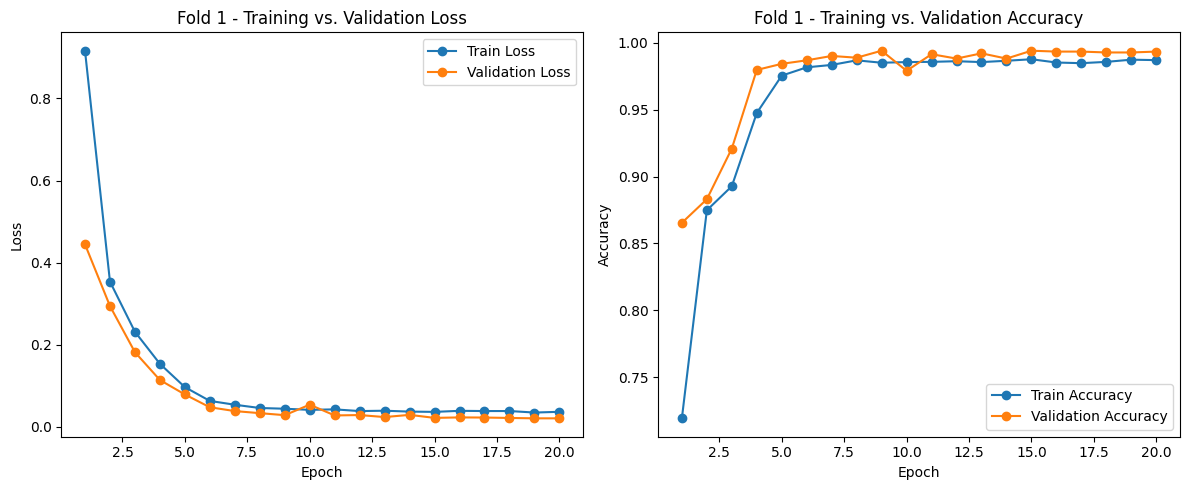

Fold 2:-----
Fold 2, Epoch 1/20 - Train Loss: 0.8636, Train Acc: 0.7513 | Val Loss: 0.4109, Val Acc: 0.8876
Fold 2, Epoch 2/20 - Train Loss: 0.3225, Train Acc: 0.8868 | Val Loss: 0.2528, Val Acc: 0.8869
Fold 2, Epoch 3/20 - Train Loss: 0.1983, Train Acc: 0.9132 | Val Loss: 0.1549, Val Acc: 0.9536
Fold 2, Epoch 4/20 - Train Loss: 0.1138, Train Acc: 0.9704 | Val Loss: 0.0839, Val Acc: 0.9752
Fold 2, Epoch 5/20 - Train Loss: 0.0688, Train Acc: 0.9809 | Val Loss: 0.0591, Val Acc: 0.9797
Fold 2, Epoch 6/20 - Train Loss: 0.0570, Train Acc: 0.9833 | Val Loss: 0.0648, Val Acc: 0.9745
Fold 2, Epoch 7/20 - Train Loss: 0.0502, Train Acc: 0.9853 | Val Loss: 0.0523, Val Acc: 0.9810
Fold 2, Epoch 8/20 - Train Loss: 0.0457, Train Acc: 0.9856 | Val Loss: 0.0427, Val Acc: 0.9837
Fold 2, Epoch 9/20 - Train Loss: 0.0426, Train Acc: 0.9868 | Val Loss: 0.0502, Val Acc: 0.9784
Fold 2, Epoch 10/20 - Train Loss: 0.0433, Train Acc: 0.9846 | Val Loss: 0.0381, Val Acc: 0.9869
Fold 2, Epoch 11/20 - Train Loss: 0.

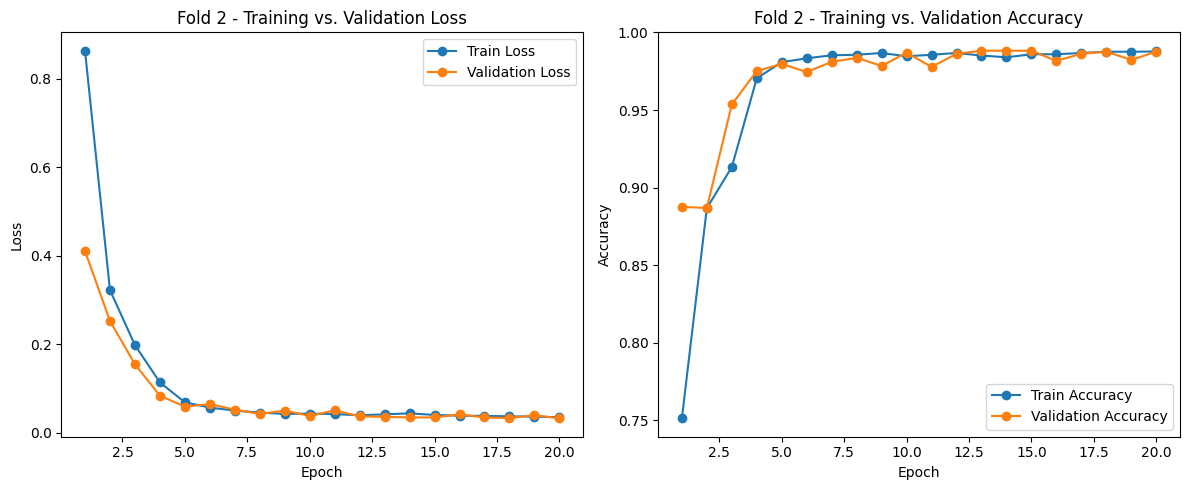

Fold 3:-----
Fold 3, Epoch 1/20 - Train Loss: 0.9052, Train Acc: 0.8802 | Val Loss: 0.4375, Val Acc: 0.8608
Fold 3, Epoch 2/20 - Train Loss: 0.3494, Train Acc: 0.8765 | Val Loss: 0.2804, Val Acc: 0.8810
Fold 3, Epoch 3/20 - Train Loss: 0.2251, Train Acc: 0.8907 | Val Loss: 0.1778, Val Acc: 0.8987
Fold 3, Epoch 4/20 - Train Loss: 0.1319, Train Acc: 0.9546 | Val Loss: 0.0897, Val Acc: 0.9771
Fold 3, Epoch 5/20 - Train Loss: 0.0748, Train Acc: 0.9791 | Val Loss: 0.0649, Val Acc: 0.9817
Fold 3, Epoch 6/20 - Train Loss: 0.0532, Train Acc: 0.9833 | Val Loss: 0.0433, Val Acc: 0.9869
Fold 3, Epoch 7/20 - Train Loss: 0.0465, Train Acc: 0.9848 | Val Loss: 0.0421, Val Acc: 0.9863
Fold 3, Epoch 8/20 - Train Loss: 0.0405, Train Acc: 0.9871 | Val Loss: 0.0400, Val Acc: 0.9856
Fold 3, Epoch 9/20 - Train Loss: 0.0391, Train Acc: 0.9869 | Val Loss: 0.0371, Val Acc: 0.9882
Fold 3, Epoch 10/20 - Train Loss: 0.0388, Train Acc: 0.9863 | Val Loss: 0.0313, Val Acc: 0.9895
Fold 3, Epoch 11/20 - Train Loss: 0.

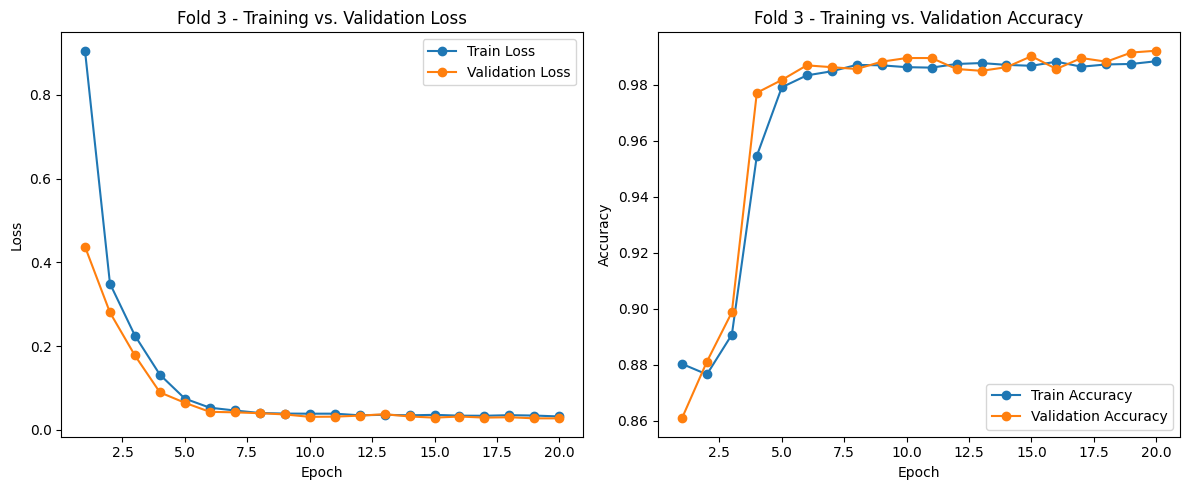

Fold 4:-----
Fold 4, Epoch 1/20 - Train Loss: 0.8959, Train Acc: 0.8067 | Val Loss: 0.4571, Val Acc: 0.8510
Fold 4, Epoch 2/20 - Train Loss: 0.3520, Train Acc: 0.8744 | Val Loss: 0.2561, Val Acc: 0.8876
Fold 4, Epoch 3/20 - Train Loss: 0.1865, Train Acc: 0.9240 | Val Loss: 0.1157, Val Acc: 0.9745
Fold 4, Epoch 4/20 - Train Loss: 0.0911, Train Acc: 0.9752 | Val Loss: 0.0677, Val Acc: 0.9784
Fold 4, Epoch 5/20 - Train Loss: 0.0607, Train Acc: 0.9809 | Val Loss: 0.0622, Val Acc: 0.9824
Fold 4, Epoch 6/20 - Train Loss: 0.0507, Train Acc: 0.9846 | Val Loss: 0.0493, Val Acc: 0.9824
Fold 4, Epoch 7/20 - Train Loss: 0.0452, Train Acc: 0.9863 | Val Loss: 0.0469, Val Acc: 0.9837
Fold 4, Epoch 8/20 - Train Loss: 0.0428, Train Acc: 0.9864 | Val Loss: 0.0456, Val Acc: 0.9843
Fold 4, Epoch 9/20 - Train Loss: 0.0391, Train Acc: 0.9866 | Val Loss: 0.0429, Val Acc: 0.9837
Fold 4, Epoch 10/20 - Train Loss: 0.0392, Train Acc: 0.9856 | Val Loss: 0.0467, Val Acc: 0.9824
Fold 4, Epoch 11/20 - Train Loss: 0.

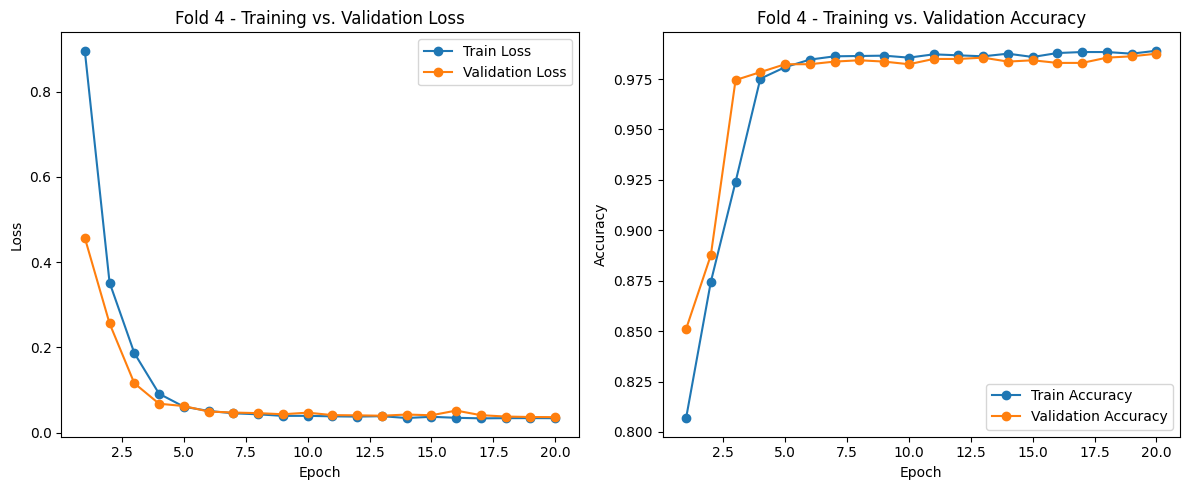

Fold 5:-----
Fold 5, Epoch 1/20 - Train Loss: 0.9665, Train Acc: 0.7678 | Val Loss: 0.5373, Val Acc: 0.8386
Fold 5, Epoch 2/20 - Train Loss: 0.3670, Train Acc: 0.8620 | Val Loss: 0.2542, Val Acc: 0.8830
Fold 5, Epoch 3/20 - Train Loss: 0.1750, Train Acc: 0.9356 | Val Loss: 0.1355, Val Acc: 0.9752
Fold 5, Epoch 4/20 - Train Loss: 0.0935, Train Acc: 0.9757 | Val Loss: 0.0684, Val Acc: 0.9843
Fold 5, Epoch 5/20 - Train Loss: 0.0680, Train Acc: 0.9781 | Val Loss: 0.0606, Val Acc: 0.9837
Fold 5, Epoch 6/20 - Train Loss: 0.0606, Train Acc: 0.9810 | Val Loss: 0.0610, Val Acc: 0.9830
Fold 5, Epoch 7/20 - Train Loss: 0.0505, Train Acc: 0.9838 | Val Loss: 0.0482, Val Acc: 0.9863
Fold 5, Epoch 8/20 - Train Loss: 0.0467, Train Acc: 0.9843 | Val Loss: 0.0475, Val Acc: 0.9856
Fold 5, Epoch 9/20 - Train Loss: 0.0435, Train Acc: 0.9843 | Val Loss: 0.0452, Val Acc: 0.9856
Fold 5, Epoch 10/20 - Train Loss: 0.0443, Train Acc: 0.9845 | Val Loss: 0.0449, Val Acc: 0.9856
Fold 5, Epoch 11/20 - Train Loss: 0.

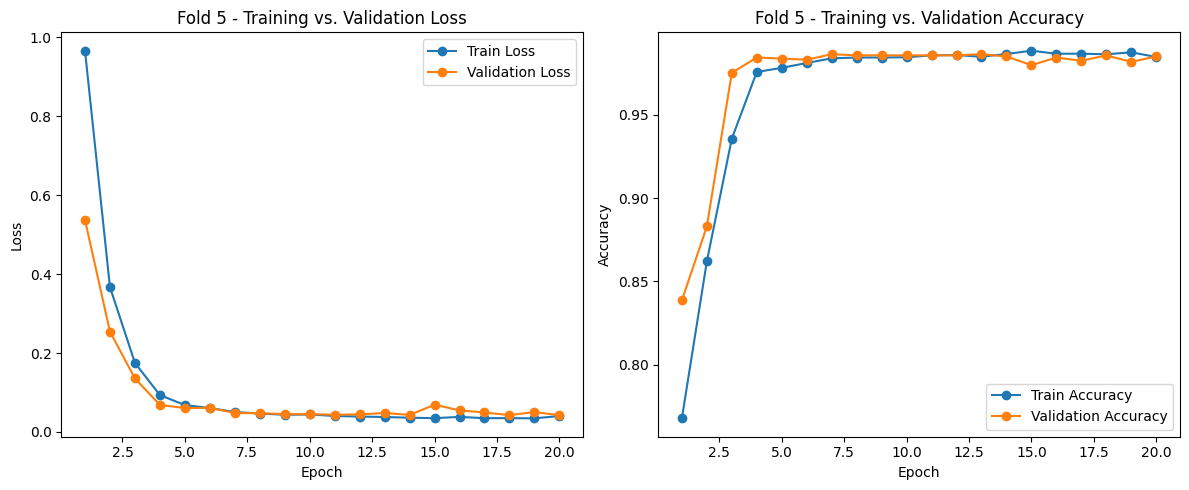

In [145]:
fold_num = 1
for train_idx, val_idx in skf.split(X_combined, y):
    print(f"Fold {fold_num}:-----")
    # Split data for current fold
    X_train, X_val = X_combined[train_idx], X_combined[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    # Split combined features into sensor and temperature parts
    X_sensor_train, X_temp_train = split_features(X_train)
    X_sensor_val, X_temp_val = split_features(X_val)

    # Convert numpy arrays to torch tensors
    X_sensor_train = torch.tensor(X_sensor_train, dtype=torch.float32).to(device)
    X_temp_train = torch.tensor(X_temp_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_fold, dtype=torch.long).to(device)

    X_sensor_val = torch.tensor(X_sensor_val, dtype=torch.float32).to(device)
    X_temp_val = torch.tensor(X_temp_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val_fold, dtype=torch.long).to(device)

    # Initialize a fresh model for this fold and apply custom weight initialization
    model = PIRvisionLSTM(input_dim=1, lstm_hidden_dim=lstm_hidden_dim, fc_hidden_dim=32,
                          output_dim=3, dropout=dropout_rate).to(device)
    model.apply(init_weights)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    n_train = X_sensor_train.shape[0]

     # Lists to record epoch-by-epoch metrics for the current fold
    fold_train_losses = []
    fold_val_losses = []
    fold_train_acc = []
    fold_val_acc = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        correct_train = 0

        # Shuffle training data indices
        permutation = torch.randperm(n_train)
        for i in range(0, n_train, batch_size):
            indices = permutation[i:i+batch_size]
            batch_sensor = X_sensor_train[indices]
            batch_temp = X_temp_train[indices]
            batch_y = y_train_tensor[indices]

            optimizer.zero_grad()
            outputs = model(batch_sensor, batch_temp)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * batch_sensor.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == batch_y).sum().item()

        train_loss = epoch_loss / n_train
        train_accuracy = correct_train / n_train

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            outputs_val = model(X_sensor_val, X_temp_val)
            val_loss = criterion(outputs_val, y_val_tensor).item()
            _, preds_val = torch.max(outputs_val, 1)
            correct_val = (preds_val == y_val_tensor).sum().item()
            val_accuracy = correct_val / X_sensor_val.shape[0]

        fold_train_losses.append(train_loss)
        fold_val_losses.append(val_loss)
        fold_train_acc.append(train_accuracy)
        fold_val_acc.append(val_accuracy)

        print(f"Fold {fold_num}, Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    # Save epoch curves for this fold for later visualization
    all_train_loss_curves.append(fold_train_losses)
    all_val_loss_curves.append(fold_val_losses)
    all_train_acc_curves.append(fold_train_acc)
    all_val_acc_curves.append(fold_val_acc)

    # Evaluate metrics on the validation set for this fold
    model.eval()
    with torch.no_grad():
        outputs_val = model(X_sensor_val, X_temp_val)
        _, preds_val = torch.max(outputs_val, 1)

    preds_val_np = preds_val.cpu().numpy()
    y_val_np = y_val_tensor.cpu().numpy()

    fold_acc = accuracy_score(y_val_np, preds_val_np)
    fold_macro = f1_score(y_val_np, preds_val_np, average='macro')
    fold_prec = precision_score(y_val_np, preds_val_np, average=None, zero_division=0)
    fold_rec = recall_score(y_val_np, preds_val_np, average=None, zero_division=0)
    fold_f1 = f1_score(y_val_np, preds_val_np, average=None, zero_division=0)
    fold_cm = confusion_matrix(y_val_np, preds_val_np)

    fold_accuracies.append(fold_acc)
    fold_macro_f1.append(fold_macro)
    fold_precisions.append(fold_prec)
    fold_recalls.append(fold_rec)
    fold_f1s.append(fold_f1)
    fold_confusion_matrices.append(fold_cm)

    checkpoint_path = f'fold{fold_num}_checkpoint.pth'
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Checkpoint saved for Fold {fold_num} at {checkpoint_path}")

    # Plot Training vs. Validation Loss and Accuracy for this fold
    epochs_range = range(1, num_epochs+1)
    plt.figure(figsize=(12, 5))
    # Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, fold_train_losses, label="Train Loss", marker='o')
    plt.plot(epochs_range, fold_val_losses, label="Validation Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Fold {fold_num} - Training vs. Validation Loss")
    plt.legend()
    # Accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, fold_train_acc, label="Train Accuracy", marker='o')
    plt.plot(epochs_range, fold_val_acc, label="Validation Accuracy", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Fold {fold_num} - Training vs. Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    fold_num += 1


Report of cross-validation metrics

In [146]:
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
mean_macro_f1 = np.mean(fold_macro_f1)
total_cm = np.sum(fold_confusion_matrices, axis=0)

print("overall 5-Fold Cross-Validation Metrics")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation of Accuracy: {std_accuracy:.4f}")
print(f"Mean Macro F1-Score: {mean_macro_f1:.4f}\n")
for i in range(len(fold_accuracies)):
    print(f"Fold {i+1} Class-wise Precision: {fold_precisions[i]}")
    print(f"Fold {i+1} Class-wise Recall:    {fold_recalls[i]}")
    print(f"Fold {i+1} Class-wise F1:        {fold_f1s[i]}\n")
print("Total Confusion Matrix (over folds):")
print(total_cm)

overall 5-Fold Cross-Validation Metrics
Mean Accuracy: 0.9892
Standard Deviation of Accuracy: 0.0032
Mean Macro F1-Score: 0.9811

Fold 1 Class-wise Precision: [0.99520767 0.97560976 1.        ]
Fold 1 Class-wise Recall:    [0.9968     0.96385542 1.        ]
Fold 1 Class-wise F1:        [0.9960032  0.96969697 1.        ]

Fold 2 Class-wise Precision: [0.99122107 0.95092025 1.        ]
Fold 2 Class-wise Recall:    [0.9936     0.93373494 1.        ]
Fold 2 Class-wise F1:        [0.99240911 0.94224924 1.        ]

Fold 3 Class-wise Precision: [0.99440448 0.96969697 1.        ]
Fold 3 Class-wise Recall:    [0.9959968  0.95808383 1.        ]
Fold 3 Class-wise F1:        [0.9952     0.96385542 1.        ]

Fold 4 Class-wise Precision: [0.99121406 0.95121951 1.        ]
Fold 4 Class-wise Recall:    [0.99359488 0.93413174 1.        ]
Fold 4 Class-wise F1:        [0.99240304 0.94259819 1.        ]

Fold 5 Class-wise Precision: [0.9911859  0.92857143 1.        ]
Fold 5 Class-wise Recall:    [0.99

In [147]:
def evaluate_model(datafile_location, checkpoint):
    import pandas as pd
    import numpy as np
    import torch
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import accuracy_score

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load evaluation data
    df = pd.read_csv(datafile_location)
    df['Label'] = df['Label'].apply(lambda x: 2 if x == 3 else x)

    # Extract features
    sensor_cols = [f'PIR_{i}' for i in range(1,56)]
    X_sensor = df[sensor_cols].values.astype(np.float32)
    X_temp = df[['Temperature_F']].values.astype(np.float32)
    y_true = df['Label'].values.astype(np.int64)

    # Normalize features (re-fitting here; ideally use saved scalers from training)
    sensor_scaler = StandardScaler()
    temp_scaler = StandardScaler()
    X_sensor_scaled = sensor_scaler.fit_transform(X_sensor)
    X_temp_scaled = temp_scaler.fit_transform(X_temp)

    # Combine features
    X_combined = np.hstack((X_sensor_scaled, X_temp_scaled))

    # Split combined features into sensor and temperature parts
    def split_features(X):
        X_sensor_part = X[:, :55].reshape(-1, 55, 1)
        X_temp_part = X[:, 55].reshape(-1, 1)
        return X_sensor_part, X_temp_part
    X_sensor_eval, X_temp_eval = split_features(X_combined)

    # Convert to torch tensors
    X_sensor_eval = torch.tensor(X_sensor_eval, dtype=torch.float32).to(device)
    X_temp_eval = torch.tensor(X_temp_eval, dtype=torch.float32).to(device)
    y_true_tensor = torch.tensor(y_true, dtype=torch.long).to(device)

    # Initialize the model (ensure the model class PIRvisionLSTM is defined in the notebook)
    model = PIRvisionLSTM(input_dim=1, lstm_hidden_dim=64, fc_hidden_dim=32,
                          output_dim=3, dropout=0.2).to(device)

    # Load the checkpoint (for example, from fold 3)
    model.load_state_dict(torch.load(checkpoint, map_location=device))
    model.eval()

    # Run inference on evaluation data
    with torch.no_grad():
        outputs = model(X_sensor_eval, X_temp_eval)
        _, preds = torch.max(outputs, 1)

    accuracy = accuracy_score(y_true_tensor.cpu().numpy(), preds.cpu().numpy())
    return accuracy

In [148]:
# Example usage of evaluate_model:

eval_accuracy = evaluate_model('pirvision_office_dataset2.csv', 'fold1_checkpoint.pth')
print("Evaluation Accuracy using the checkpoint from Fold 1:", eval_accuracy)

Evaluation Accuracy using the checkpoint from Fold 1: 0.9891517448699516
